In [57]:
import numpy as np
import scipy.stats as stats
from scipy.stats import norm
from sklearn.metrics import mean_squared_error
from scipy.optimize import minimize
import matplotlib.pyplot as plt

## Heston Model

In [58]:
def simulate_heston_model(mu, kappa, theta, sigma, rho, T, N, S0, v0):
    dt = T / N
    prices = np.zeros(N)
    variance = np.zeros(N)

    prices[0] = S0
    variance[0] = v0

    for t in range(1, N):
        wt = np.random.normal(0, np.sqrt(dt))
        wv = rho * wt + np.sqrt(1 - rho ** 2) * np.random.normal(0, np.sqrt(dt))

        variance[t] = np.abs(variance[t - 1] + kappa * (theta - variance[t - 1]) * dt + sigma * np.sqrt(variance[t - 1]) * wv)
        prices[t] = prices[t - 1] * np.exp((mu - 0.5 * variance[t]) * dt + np.sqrt(variance[t]) * wt)

    return prices, variance

## Extend Kalman Filter

In [59]:
# Negative log-likelihood function
def negative_log_likelihood(params, u, v):
    mu, kappa, theta, sigma, rho = params
    n = len(u)
    likelihood = sum(np.log(v[i]) + (u[i]**2) / v[i] for i in range(n))
    return -likelihood

In [60]:
def estimate_extended_kalman_parameters_1_dim(log_stock_prices, N, muS, omega, theta, xi, rho):
    n_stock_prices = len(log_stock_prices)
    delt = 1.0 / N
    eps = 0.00001
    x = 0.04
    P = 0.01

    u = np.zeros(n_stock_prices)
    v = np.ones(n_stock_prices)
    estimates = np.zeros(n_stock_prices)
    u[0] = u[-1] = 0.0
    v[0] = v[-1] = 1.0
    estimates[0] = estimates[1] = log_stock_prices[0] + eps

    for i1 in range(1, n_stock_prices - 1):
        if x < 0:
            x = 0.00001

        x1 = x + (omega - rho * xi * muS - (theta - 0.5 * rho * xi) * x) * delt + rho * xi * (log_stock_prices[i1] - log_stock_prices[i1 - 1])
        A = 1.0 - (theta - 0.5 * rho * xi) * delt
        W = xi * np.sqrt((1 - rho ** 2) * x * delt)
        P1 = W ** 2 + A * P * A

        if x1 < 0:
            x1 = 0.00001

        H = -0.5 * delt
        U = np.sqrt(x1 * delt)
        K = P1 * H / (H * P1 * H + U ** 2)
        z = log_stock_prices[i1 + 1]
        x = x1 + K * (z - (log_stock_prices[i1] + (muS - 0.5 * x1) * delt))

        u[i1] = z - (log_stock_prices[i1] + (muS - 0.5 * x1) * delt)
        v[i1] = H * P1 * H + U ** 2

        initial_params = [muS, omega, theta, xi, rho]
        result = minimize(negative_log_likelihood, initial_params, args=(u, v), method='Powell')
        muS =  result.x[0]
        omega =  result.x[1]
        theta = result.x[2]
        xi = result.x[3]
        rho = result.x[4]

        estimates[i1 + 1] = log_stock_prices[i1] + (muS - 0.5 * x1) * delt
        P = (1.0 - K * H) * P1

    return u, v, estimates

In [61]:
mu = 0.05
kappa = 1.5
theta = 0.04
sigma = 0.3
rho = -0.6
T = 1.0
N = 252
S0 = 100
v0 = 0.04

In [62]:
stock_prices, variances = simulate_heston_model(mu, kappa, theta, sigma, rho, T, N, S0, v0)

In [63]:
log_stock_prices = np.log(stock_prices)

In [64]:
u, v, estimates = estimate_extended_kalman_parameters_1_dim(log_stock_prices, N, mu, kappa, theta, sigma, rho)

In [65]:
rmse = np.sqrt(mean_squared_error(stock_prices, np.exp(estimates)))
rmse

1.186849145034189

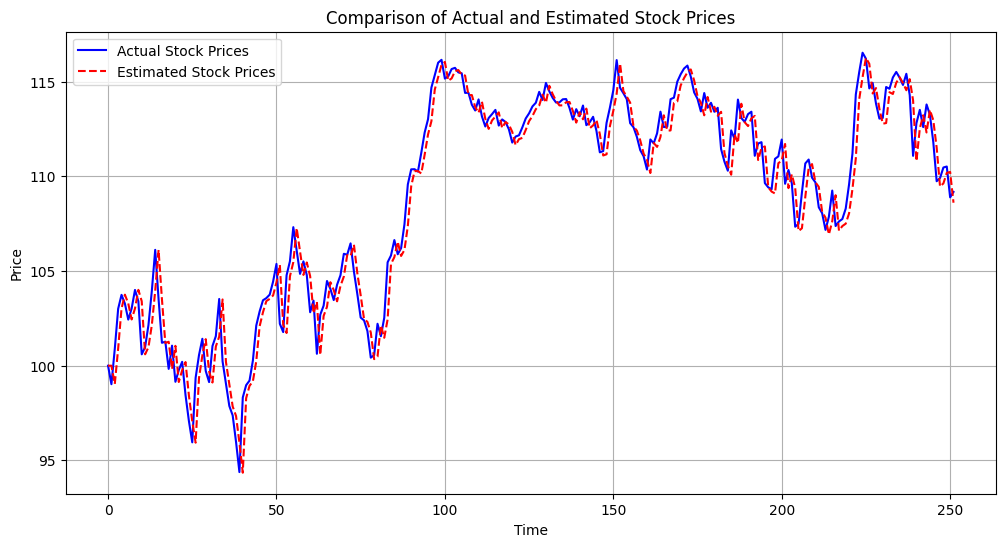

In [66]:
plt.figure(figsize=(12, 6))
plt.plot(stock_prices, label='Actual Stock Prices', color='blue')
plt.plot(np.exp(estimates), label='Estimated Stock Prices', color='red', linestyle='--')
plt.title('Comparison of Actual and Estimated Stock Prices')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()



In [67]:
guess_mu = 0.1
guess_kappa = 1.0
guess_theta = 0
guess_sigma = 0.1
guess_rho = 0

In [68]:
u, v, estimates = estimate_extended_kalman_parameters_1_dim(log_stock_prices, N, guess_mu, guess_kappa, guess_theta, guess_sigma, guess_rho)

In [69]:
rmse = np.sqrt(mean_squared_error(stock_prices, np.exp(estimates)))
rmse

1.1784792572162717

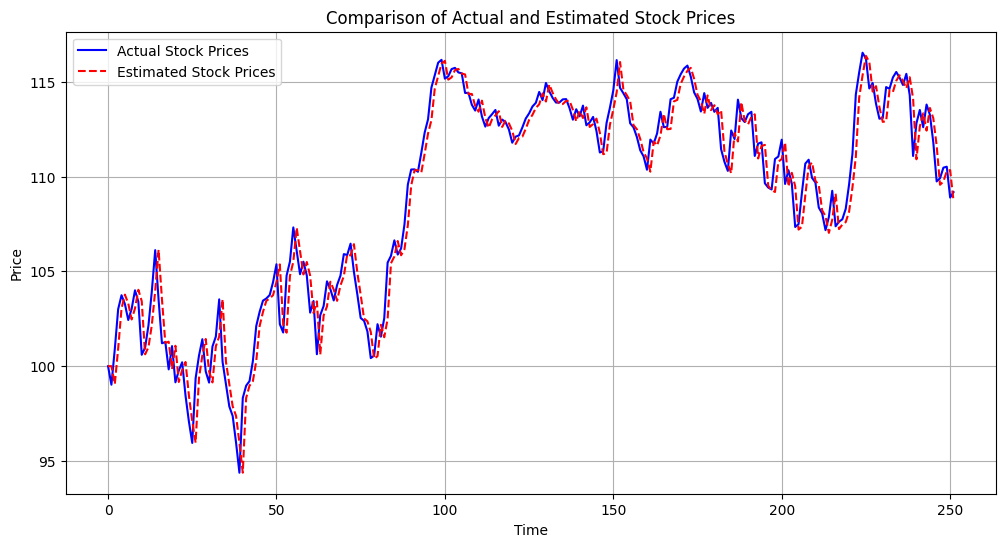

In [70]:
plt.figure(figsize=(12, 6))
plt.plot(stock_prices, label='Actual Stock Prices', color='blue')
plt.plot(np.exp(estimates), label='Estimated Stock Prices', color='red', linestyle='--')
plt.title('Comparison of Actual and Estimated Stock Prices')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

## Particle Extend Kalman Filter

In [71]:
def estimate_particle_extended_kalman_parameters_1_dim(log_stock_prices, muS, omega, theta, xi, rho):

    n_stock_prices = len(log_stock_prices)
    M = 1000
    delt = 1.0 / 252.0
    A = 1.0 - (theta - 0.5 * rho * xi) * delt
    H = -0.5 * delt
    x0 = 0.04
    P0 = 0.000001
    x = x0 + np.sqrt(P0) * np.random.normal(size=M)
    P = np.full(M, P0)
    ll = 0.0
    estimates = np.zeros(n_stock_prices)

    for i1 in range(1, n_stock_prices - 1):
        l = 0.0
        x1_sum = 0.0
        x1, x2, xx, W, P1, U, K, w = np.zeros(M), np.zeros(M), np.zeros(M), np.zeros(M), np.zeros(M), np.zeros(M), np.zeros(M), np.zeros(M)

        for i2 in range(M):
            if x[i2] < 0:
                x[i2] = 0.00001

            x1[i2] = x[i2] + (omega - rho * xi * muS - (theta - 0.5 * rho * xi) * x[i2]) * delt + rho * xi * (log_stock_prices[i1] - log_stock_prices[i1 - 1])
            W[i2] = xi * np.sqrt((1 - rho ** 2) * x[i2] * delt)
            P1[i2] = W[i2] ** 2 + A * P[i2] * A

            if x1[i2] < 0:
                x1[i2] = 0.00001

            U[i2] = np.sqrt(x1[i2] * delt)
            K[i2] = P1[i2] * H / (H * P1[i2] * H + U[i2] ** 2)
            z = log_stock_prices[i1 + 1]
            x2[i2] = x1[i2] + K[i2] * (z - (log_stock_prices[i1] + (muS - 0.5 * x1[i2]) * delt))
            x1_sum += x1[i2]
            P[i2] = (1.0 - K[i2] * H) * P1[i2]
            xx[i2] = x2[i2] + np.sqrt(P[i2]) * np.random.normal()

            if xx[i2] < 0:
                xx[i2] = 0.00001

            m = x2[i2]
            s = np.sqrt(P[i2])
            q = stats.norm.pdf(xx[i2], loc=m, scale=s)
            m = log_stock_prices[i1] + (muS - 0.5 * xx[i2]) * delt
            s = np.sqrt(xx[i2] * delt)
            pz = stats.norm.pdf(z, loc=m, scale=s)
            m = x[i2] + (omega - rho * xi * muS - (theta - 0.5 * rho * xi) * x[i2]) * delt + rho * xi * (log_stock_prices[i1] - log_stock_prices[i1 - 1])
            s = xi * np.sqrt((1 - rho ** 2) * x[i2] * delt)
            px = stats.norm.pdf(xx[i2], loc=m, scale=s)
            w[i2] = pz * px / max(q, 1.0e-10)
            l += w[i2]

        ll += np.log(l)
        estimates[i1 + 1] = log_stock_prices[i1] + (muS - 0.5 * x1_sum / M) * delt
        w /= l
        # resample and reset weights
        c = np.cumsum(w)
        u = np.linspace(1.0 / M, 1, M) - np.random.uniform(0, 1.0 / M)
        indices = np.searchsorted(c, u, side='right') - 1
        indices = np.clip(indices, 0, M-1)
        x, w = xx[indices], np.full(M, 1.0 / M)

    ll *= -1.0 #ll is result for the likehood function, able to minimize it to get parameter
    initial_params = [muS, omega, theta, xi, rho]

    return ll, estimates

In [72]:
guess_mu = 0.1
guess_kappa = 1.0
guess_theta = 0
guess_sigma = 0.1
guess_rho = 0

In [73]:
# Example usage
ll, estimates = estimate_particle_extended_kalman_parameters_1_dim(log_stock_prices, guess_mu, guess_kappa, guess_theta, guess_sigma, guess_rho)

In [74]:
rmse = np.sqrt(mean_squared_error(stock_prices, np.exp(estimates)))
rmse

8.854375298791744

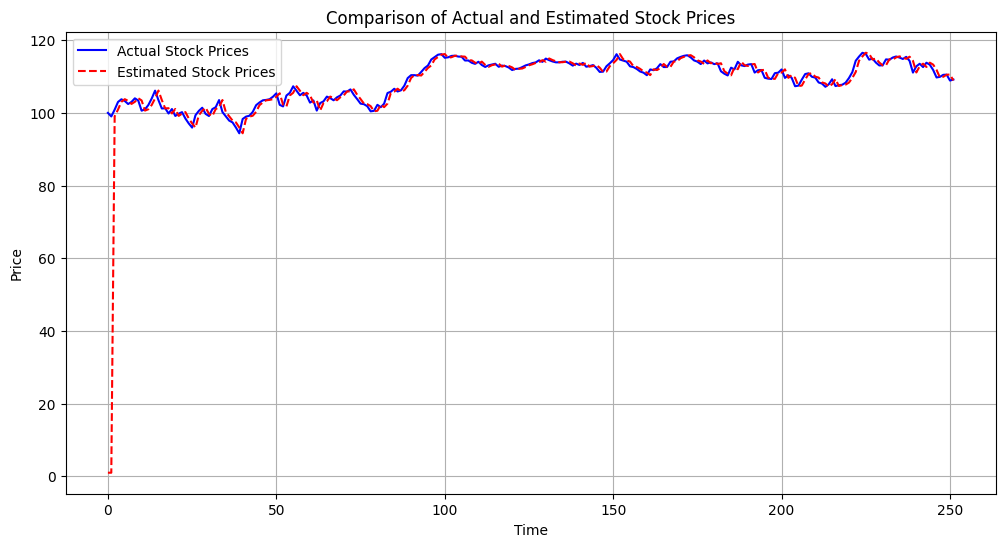

In [75]:
plt.figure(figsize=(12, 6))
plt.plot(stock_prices, label='Actual Stock Prices', color='blue')
plt.plot(np.exp(estimates), label='Estimated Stock Prices', color='red', linestyle='--')
plt.title('Comparison of Actual and Estimated Stock Prices')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

## Bates Model (Add Merton log-normal jump to Heston Model)

In [76]:
def simulate_bates_model(S0, mu, v0, rho, kappa, theta, xi, lambda_jump, alpha, delta, T, N):
    dt = T / N  # time increment
    S = np.zeros(N)
    v = np.zeros(N)
    S[0] = S0
    v[0] = v0

    for t in range(1, N):

        Z1 = np.random.normal(0, np.sqrt(dt))
        Z2 = np.random.normal(0, np.sqrt(dt))
        Z2 = rho * Z1 + np.sqrt(1 - rho ** 2) * Z2

        # Check for jumps
        if np.random.poisson(lambda_jump * dt) > 0:
            J = np.exp(alpha + delta * np.random.normal()) - 1
        else:
            J = 0

        v[t] = v[t-1] + kappa * (theta - max(v[t-1], 0)) * dt + xi * np.sqrt(max(v[t-1], 0)) * Z2
        S[t] = S[t-1] * (1 + mu * dt + np.sqrt(max(v[t-1], 0)) * Z1 + J)

    return S, v

In [77]:
S0 = 100        # Initial stock price
mu = 0.05       # Expected return
v0 = 0.04       # Initial variance
rho = -0.6      # Correlation between stock and variance
kappa = 1.5     # Speed of mean reversion
theta = 0.04    # Long-term variance
xi = 0.3        # Volatility of volatility
lambda_jump = 1 # Intensity of the Poisson jump process
alpha = -0.1    # Mean of log-normal jump size
delta = 0.1     # Standard deviation of log-normal jump size
T = 1.0         # Total time
N = 252         # Number of steps

In [78]:
Stock_price_jump, Variance_price_jump = simulate_bates_model(S0, mu, v0, rho, kappa, theta, xi, lambda_jump, alpha, delta, T, N)

In [106]:
log_stock_prices = np.log(Stock_price_jump)

## Solve Extend Kalman Filter in Jump

In [108]:
# Negative log-likelihood function
def negative_log_likelihood_bates(params, u, v):
    muS, omega, theta, xi, rho, lambda_, sigma_J = params
    n = len(u)
    likelihood = sum(np.log(v[i]) + (u[i]**2) / v[i] for i in range(n))
    return -likelihood

In [109]:
def estimate_extended_kalman_parameters_bates(log_stock_prices, N, muS, omega, theta, xi, rho, lambda_, j):
    n_stock_prices = len(log_stock_prices)
    delt = 1.0 / N
    x = 0.04
    P = 0.01

    u = np.zeros(n_stock_prices)
    v = np.ones(n_stock_prices)
    estimates = np.zeros(n_stock_prices)
    estimates[0] = log_stock_prices[0]

    # Jump component initialization
    mu_k = 0

    for i1 in range(1, n_stock_prices - 1):
        if x < 0:
            x = 0.00001

        if np.random.uniform() < 1 - np.exp(-lambda_ * delt):
            mu_k = np.log(1 - j)
        else:
            mu_k = 0

        estimates[i1] = estimates[i1 - 1] + (muS - 0.5 * x + lambda_ * j) * delt + np.sqrt(x * delt) * np.random.normal()

        x1 = x + (omega - theta * x) * delt + xi * np.sqrt(x * delt) * np.random.normal() - rho * (estimates[i1] - estimates[i1 - 1])

        if x1 < 0:
            x1 = 0.00001

        H = -0.5 * delt
        U = np.sqrt(x1 * delt)
        K = P * H / (H * P * H + U ** 2)
        P1 = P - K * H * P

        z = log_stock_prices[i1 + 1]
        x = x1 + K * (z - estimates[i1])

        u[i1] = z - estimates[i1]
        v[i1] = H * P1 * H + U ** 2


        initial_params = [muS, omega, theta, xi, rho, lambda_, j]
        result = minimize(negative_log_likelihood_bates, initial_params, args=(u, v), method='Powell')
        muS =  result.x[0]
        omega =  result.x[1]
        theta = result.x[2]
        xi = result.x[3]
        rho = result.x[4]
        lambda_ = result.x[5]
        j = result.x[6]

        P = (1.0 - K * H) * P1

    estimates[-1] = estimates[-2] + (muS - 0.5 * x + lambda_ * j) * delt + np.sqrt(x * delt) * np.random.normal()

    return u, v, estimates

In [110]:
u, v, estimates = estimate_extended_kalman_parameters_bates(log_stock_prices, N, mu, kappa, theta, xi, rho, lambda_ = 5, j = 0.2)

In [111]:
rmse = np.sqrt(mean_squared_error(Stock_price_jump, np.exp(estimates)))
rmse

121.87467988554997

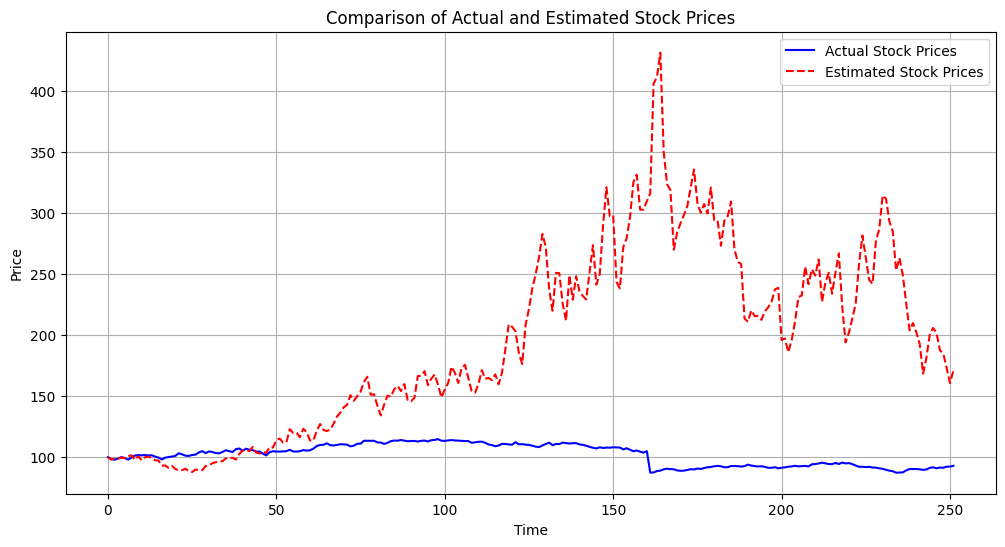

In [112]:
plt.figure(figsize=(12, 6))
plt.plot(Stock_price_jump, label='Actual Stock Prices', color='blue')
plt.plot(np.exp(estimates), label='Estimated Stock Prices', color='red', linestyle='--')
plt.title('Comparison of Actual and Estimated Stock Prices')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

## Solve Particle Extend Kalman Filter in Jump

In [88]:
def estimate_particle_jump_diffusion_parameters_1_dim(log_stock_prices, muS, omega, theta, xi, rho, lambda_, j):

    n_stock_prices = len(log_stock_prices)
    M = 1000
    delt = 1.0 / N
    A = 1.0 - (theta - 0.5 * rho * xi) * delt
    H = -0.5 * delt
    x0 = 0.04
    P0 = 0.000001
    x = np.random.normal(x0, np.sqrt(P0), M)
    mu = np.zeros(M)
    P = np.full(M, P0)
    ll = 0.0
    estimates = np.zeros(n_stock_prices)

    for i1 in range(1, n_stock_prices-1):
        l = 0.0
        x1_sum = 0.0
        m1_sum = 0.0
        x1 = np.zeros(M)
        x2 = np.zeros(M)
        P1 = np.zeros(M)
        W = np.zeros(M)
        K = np.zeros(M)
        xx = np.zeros(M)
        mm = np.zeros(M)
        w = np.zeros(M)
        c = np.zeros(M)
        m1 = mu.copy()
        m2 = np.zeros(M)

        for i2 in range(M):
            # EKF for the proposal distribution
            x[i2] = max(x[i2], 0.00001)
            x1[i2] = x[i2] + (omega - rho * xi * (muS + lambda_ * j) - (theta - 0.5 * rho * xi) * x[i2]) * delt + rho * xi * (log_stock_prices[i1] - log_stock_prices[i1-1]) - rho * xi * mu[i2]
            x1[i2] = max(x1[i2], 0.00001)
            W[i2] = xi * np.sqrt((1 - rho**2) * x[i2] * delt)
            P1[i2] = W[i2]**2 + A * P[i2] * A
            U = np.sqrt(x1[i2] * delt)
            K[i2] = P1[i2] * H / (H * P1[i2] * H + U**2)
            z = log_stock_prices[i1+1]
            x2[i2] = x1[i2] + K[i2] * (z - (log_stock_prices[i1] + (muS + lambda_ * j - 0.5 * x1[i2]) * delt + m1[i2]))
            P[i2] = (1.0 - K[i2] * H) * P1[i2]
            xx[i2] = x2[i2] + np.sqrt(P[i2]) * norm.ppf(np.random.random())
            xx[i2] = max(xx[i2], 0.00001)
            mm[i2] = np.log(1.0 - j) if np.random.random() < np.exp(-lambda_ * delt) else 0.0
            m = x2[i2]
            s = np.sqrt(P[i2])
            q = 0.39894228 / s * np.exp(-0.5 * (xx[i2] - m)**2 / s**2)
            m = log_stock_prices[i1] + (muS + lambda_ * j - 0.5 * xx[i2]) * delt + mm[i2]
            s = np.sqrt(xx[i2] * delt)
            pz = 0.39894228 / s * np.exp(-0.5 * (z - m)**2 / s**2)
            m = x[i2] + (omega - rho * xi * (muS + lambda_ * j) - (theta - 0.5 * rho * xi) * x[i2]) * delt + rho * xi * (log_stock_prices[i1] - log_stock_prices[i1-1]) - rho * xi * mu[i2]
            s = xi * np.sqrt((1 - rho**2) * x[i2] * delt)
            px = 0.39894228 / s * np.exp(-0.5 * (xx[i2] - m)**2 / s**2)
            w[i2] = pz * px / max(q, 1.0e-10)
            l += w[i2]
            x1_sum += x1[i2]
            m1_sum += m1[i2]

        ll += np.log(l)
        estimates[i1+1] = log_stock_prices[i1] + (muS + lambda_ * j - 0.5 * x1_sum / M) * delt + m1_sum / M

        # normalize weights
        w /= l
        # resample and reset weights
        c = np.cumsum(w)
        u = np.linspace(0, 1-1/M, M) + 1.0/M * np.random.random()
        indices = np.searchsorted(c, u)
        x = xx[indices]
        mu = mm[indices]
        w = np.full(M, 1.0/M)

    ll *= -1.0
    return ll, estimates


In [85]:
log_stock_prices = np.log(Stock_price_jump)

In [93]:
ll, estimates = estimate_particle_jump_diffusion_parameters_1_dim(log_stock_prices, mu, kappa, theta, xi, rho, lambda_ = 5, j = 0.2)

In [94]:
rmse = np.sqrt(mean_squared_error(Stock_price_jump, np.exp(estimates)))
rmse

9.264953912605028

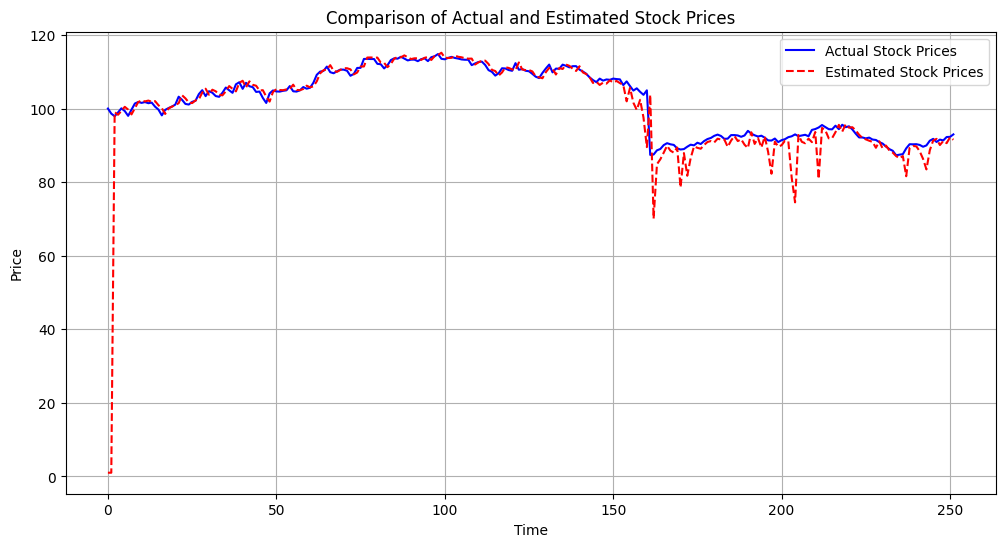

In [95]:
plt.figure(figsize=(12, 6))
plt.plot(Stock_price_jump, label='Actual Stock Prices', color='blue')
plt.plot(np.exp(estimates), label='Estimated Stock Prices', color='red', linestyle='--')
plt.title('Comparison of Actual and Estimated Stock Prices')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

In [98]:
guess_mu = 0.1
guess_kappa = 1.0
guess_theta = 0
guess_sigma = 0.1
guess_rho = 0
lambda_ = 8
j = 0.1

In [99]:
ll, estimates = estimate_particle_jump_diffusion_parameters_1_dim(log_stock_prices, guess_mu, guess_kappa, guess_theta, guess_sigma, guess_rho, lambda_, j)

In [100]:
rmse = np.sqrt(mean_squared_error(Stock_price_jump, np.exp(estimates)))
rmse

11.054787311920759

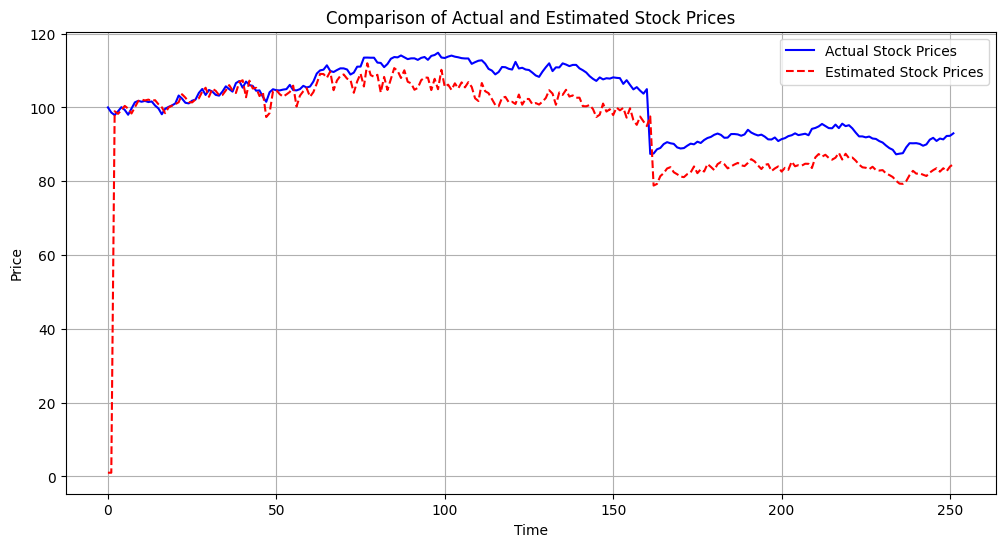

In [101]:
plt.figure(figsize=(12, 6))
plt.plot(Stock_price_jump, label='Actual Stock Prices', color='blue')
plt.plot(np.exp(estimates), label='Estimated Stock Prices', color='red', linestyle='--')
plt.title('Comparison of Actual and Estimated Stock Prices')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()